In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Google Drive'daki belirli bir klasörde bulunan şeker kamışı hastalığı veri setinin ana dizinini tanımlar. Ardından, bu ana dizin altında eğitim, doğrulama ve test veri setleri için ayrı ayrı alt dizin yollarını oluşturur. Son olarak, oluşturulan bu dizinlerin sistemde gerçekten var olup olmadığını kontrol eder ve sonuçları ekrana yazdırır.

In [ ]:
import os

# 01_data_preparation.ipynb ile aynı BASE_DIR
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/Sugarcane Disease"
SPLIT_DIR = os.path.join(BASE_DIR, "dataset_split")

train_dir = os.path.join(SPLIT_DIR, "train")
val_dir   = os.path.join(SPLIT_DIR, "val")
test_dir  = os.path.join(SPLIT_DIR, "test")

print("TRAIN:", train_dir)
print("VAL  :", val_dir)
print("TEST :", test_dir)

print("Train klasörü var mı?", os.path.exists(train_dir))
print("Val   klasörü var mı?", os.path.exists(val_dir))
print("Test  klasörü var mı?", os.path.exists(test_dir))


TRAIN: /content/drive/MyDrive/Colab Notebooks/Sugarcane Disease/dataset_split/train
VAL  : /content/drive/MyDrive/Colab Notebooks/Sugarcane Disease/dataset_split/val
TEST : /content/drive/MyDrive/Colab Notebooks/Sugarcane Disease/dataset_split/test
Train klasörü var mı? True
Val   klasörü var mı? True
Test  klasörü var mı? True


In [ ]:
!pip install scikit-learn seaborn


 Derin öğrenme modelini oluşturmak ve eğitmek için gerekli olan TensorFlow ve NumPy gibi temel kütüphaneleri içe aktarır. Ayrıca, modelin performansını detaylı bir şekilde değerlendirmek için Scikit-learn kütüphanesinden çeşitli metrikleri ve görselleştirme için Matplotlib ile Seaborn'u dahil eder.



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, matthews_corrcoef,
    precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize


IMG_SIZE ve BATCH_SIZE gibi parametrelerle TensorFlow kullanarak eğitim, doğrulama ve test görüntü veri kümelerini yükler. Veri kümeleri, belirtilen dizinlerden alınır ve etiketler kategorik formata dönüştürülür. Son olarak, sınıf isimleri ve toplam sınıf sayısı belirlenerek ekrana yazdırılır, böylece modelin temel yapılandırması tamamlanmış olur.

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Sınıflar:", class_names)
print("Sınıf sayısı:", num_classes)


Found 1762 files belonging to 5 classes.
Found 250 files belonging to 5 classes.
Found 509 files belonging to 5 classes.
Sınıflar: ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']
Sınıf sayısı: 5


Veri yükleme performansını optimize etmek için TensorFlow veri kümelerini hazırlar. AUTOTUNE, TensorFlow'un kaynakları dinamik olarak yönetmesine izin verirken, .cache() tekrar eden disk erişimini önler ve .shuffle(1000) eğitim verilerini karıştırır. Son olarak, .prefetch() eğitim devam ederken bir sonraki veri bloğunu önceden yükleyerek GPU/CPU'nun boşta kalmasını engeller.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Keras kütüphanesini kullanarak bir Evrişimsel Sinir Ağı (CNN) modeli oluşturur. Model, görüntüleri normalize eder, art arda gelen evrişim ve maksimum havuzlama katmanları ile özellik çıkarır. Çıkarılan özellikler daha sonra düzleştirilip yoğun katmanlara beslenir ve bir Dropout katmanı aşırı öğrenmeyi önlerken, son katman sınıflandırma için olasılıkları verir.


In [ ]:
from tensorflow.keras import layers, models, optimizers

def create_cnn_model(input_shape=(224, 224, 3), num_classes=3, dropout_rate=0.5):
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


Evrişimsel Sinir Ağı (CNN) modeli için en uygun öğrenme oranı ve dropout değerlerini belirlemek amacıyla bir hiperparametre arama (grid search) işlemi gerçekleştirir. Önceden tanımlanmış bir parametre ızgarasındaki her kombinasyon için kısa bir süre model eğitilir ve doğrulama doğruluğu kaydedilir. Bu süreç sonucunda, farklı parametre kombinasyonlarının validasyon performansı karşılaştırılır ve en iyi performansı veren set bulunur.


aynı yapay zekâyı farklı ayarlarla kısa kısa eğitip, sınavda (validation) en iyi sonucu veren ayarı bulmak için

In [ ]:
import pandas as pd
from tensorflow.keras import optimizers

param_grid = [
    {"lr": 1e-3, "dropout": 0.3},
    {"lr": 5e-4, "dropout": 0.3},
    {"lr": 1e-4, "dropout": 0.3},
    {"lr": 5e-4, "dropout": 0.5},
    {"lr": 1e-4, "dropout": 0.5},
]

results = []

search_epochs = 8  # arama için kısa tutuyoruz, sonra en iyisini daha uzun eğiteceğiz

for i, params in enumerate(param_grid, 1):
    print(f"\n=== Deneme {i} / {len(param_grid)} | lr={params['lr']}, dropout={params['dropout']} ===")

    model_tmp = create_cnn_model(input_shape=IMG_SIZE + (3,),
                                 num_classes=num_classes,
                                 dropout_rate=params["dropout"])

    model_tmp.compile(
        optimizer=optimizers.Adam(learning_rate=params["lr"]),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history_tmp = model_tmp.fit(
        train_ds,
        validation_data=val_ds,
        epochs=search_epochs,
        verbose=1
    )

    best_val_acc = max(history_tmp.history['val_accuracy'])
    last_train_acc = history_tmp.history['accuracy'][-1]

    print(f"--> En iyi validation accuracy: {best_val_acc:.4f}")

    results.append({
        "lr": params["lr"],
        "dropout": params["dropout"],
        "best_val_acc": best_val_acc,
        "last_train_acc": last_train_acc
    })

results_df = pd.DataFrame(results)
results_df



=== Deneme 1 / 5 | lr=0.001, dropout=0.3 ===
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 138ms/step - accuracy: 0.2356 - loss: 3.0822 - val_accuracy: 0.4200 - val_loss: 1.2813
Epoch 2/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.4818 - loss: 1.2686 - val_accuracy: 0.5880 - val_loss: 1.1038
Epoch 3/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5990 - loss: 0.9968 - val_accuracy: 0.6840 - val_loss: 0.8406
Epoch 4/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6183 - loss: 0.9817 - val_accuracy: 0.7200 - val_loss: 0.8238
Epoch 5/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.7437 - loss: 0.7113 - val_accuracy: 0.7200 - val_loss: 0.8137
Epoch 6/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7733 - loss: 0.6020 - val_accuracy: 0.7240 - val_loss: 0.7249
Epoch 7/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8335 - loss: 0.4666 - val_accuracy: 0.7520 - val_loss: 0.7646
Epoch 8/8
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8814 - loss: 0.3267 - val_accuracy: 0.7200 - val_loss: 0.8697


,lr,dropout,best_val_acc,last_train_acc
0,0.0010,0.3,0.752,0.880250
1,0.0005,0.3,0.752,0.964245
2,0.0001,0.3,0.736,0.804200
3,0.0005,0.5,0.772,0.936436
4,0.0001,0.5,0.716,0.778093


önceki hiperparametre arama sonuçlarından en iyi öğrenme oranı ve dropout değerlerini otomatik olarak seçer. Eğer sonuçlar mevcut değilse veya boşsa, varsayılan parametreler atanır. Son olarak, modelin ne kadar süreyle eğitileceğini belirten final_epochs değişkeni ayarlanır.

In [ ]:
# Eğer önceki deneme (BLo6lfLcdjIG) tamamlandıysa, buradan en iyi parametreleri çekebiliriz.
# Tamamlanmadıysa veya çıktı truncated ise, burası doğru çalışmayabilir.
if 'results_df' in locals() and not results_df.empty:
    best_params = results_df.loc[results_df["best_val_acc"].idxmax()]
    best_lr = best_params["lr"]
    best_dropout = best_params["dropout"]
    print(f"results_df'ten belirlenen en iyi öğrenme oranı (lr): {best_lr}")
    print(f"results_df'ten belirlenen en iyi dropout oranı: {best_dropout}")
else:
    # Eğer results_df boş veya tanımlı değilse, varsayılan değerleri kullan
    print("Uyarı: results_df bulunamadı veya boş. Manuel olarak atanan değerler kullanılacak.")
    best_lr = 5e-4 # Manuel olarak atanan değer
    best_dropout = 0.5 # Manuel olarak atanan değer
    print(f"Manuel olarak atanan öğrenme oranı (lr): {best_lr}")
    print(f"Manuel olarak atanan dropout oranı: {best_dropout}")

final_epochs = 20

results_df'ten belirlenen en iyi öğrenme oranı (lr): 0.0005
results_df'ten belirlenen en iyi dropout oranı: 0.5


model eğitimi sırasında validasyon doğruluğu en yüksek olan ağırlıkların otomatik olarak kaydedilmesi için ModelCheckpoint kullanılmıştır. Ayrıca modelin validasyon başarımı belirli bir süre iyileşmediğinde eğitimin erken durdurulması amacıyla EarlyStopping mekanizması eklenmiştir. Böylece modelin ezber yapması önlenmiş ve en iyi performansa sahip ağırlıklar korunmuştur.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# En iyi model ağırlıklarının kaydedileceği yol
checkpoint_path = os.path.join(BASE_DIR, "best_cnn_model.weights.h5")

# ModelCheckpoint: En iyi validasyon başarımlı modeli kaydet
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True, # Sadece ağırlıkları kaydet, tüm modeli değil
    mode='max',
    verbose=1
)

# EarlyStopping: Validasyon başarımı belirli bir süre iyileşmezse eğitimi durdur
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5, # 5 epoch boyunca iyileşme olmazsa durdur
    mode='max',
    verbose=1,
    restore_best_weights=True # Durduktan sonra en iyi ağırlıkları geri yükle
)

callbacks = [checkpoint_callback, early_stopping_callback]

daha önce belirlenen en iyi learning rate ve dropout parametreleri kullanılarak CNN modeli yeniden oluşturulmuş ve Adam optimizasyon algoritması ile derlenmiştir. Model, eğitim ve doğrulama veri kümeleri kullanılarak belirlenen epoch sayısı boyunca eğitilmiş, ModelCheckpoint ve EarlyStopping callback’leri ile en iyi ağırlıklar korunmuş ve gereksiz eğitim süreci önlenmiştir.

In [ ]:

model = create_cnn_model(input_shape=IMG_SIZE + (3,),
                         num_classes=num_classes,
                         dropout_rate=best_dropout)

model.compile(
    optimizer=optimizers.Adam(learning_rate=best_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=final_epochs,
    callbacks=callbacks # Callbacks buraya eklendi
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2436 - loss: 1.7948
Epoch 1: val_accuracy improved from -inf to 0.47200, saving model to /content/drive/MyDrive/Colab Notebooks/Sugarcane Disease/best_cnn_model.weights.h5
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.2448 - loss: 1.7910 - val_accuracy: 0.4720 - val_loss: 1.3355
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4879 - loss: 1.2904
Epoch 2: val_accuracy improved from 0.47200 to 0.61200, saving model to /content/drive/MyDrive/Colab Notebooks/Sugarcane Disease/best_cnn_model.weights.h5
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.4886 - loss: 1.2890 - val_accuracy: 0.6120 - val_loss: 1.0645
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6342 - loss: 0.9508
Epoch 3: val_accuracy improved from 0.61200 to 0.69200, saving model to /content/drive/MyDrive/Colab Notebooks/Sugarcane Disease/best_cnn_model.weights.h5
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.6345 -

modelin eğitim sürecindeki doğruluk ve hata değerlerini epoch bazında grafikleştirerek modelin öğrenme davranışını analiz etmeyi amaçlamaktadır.

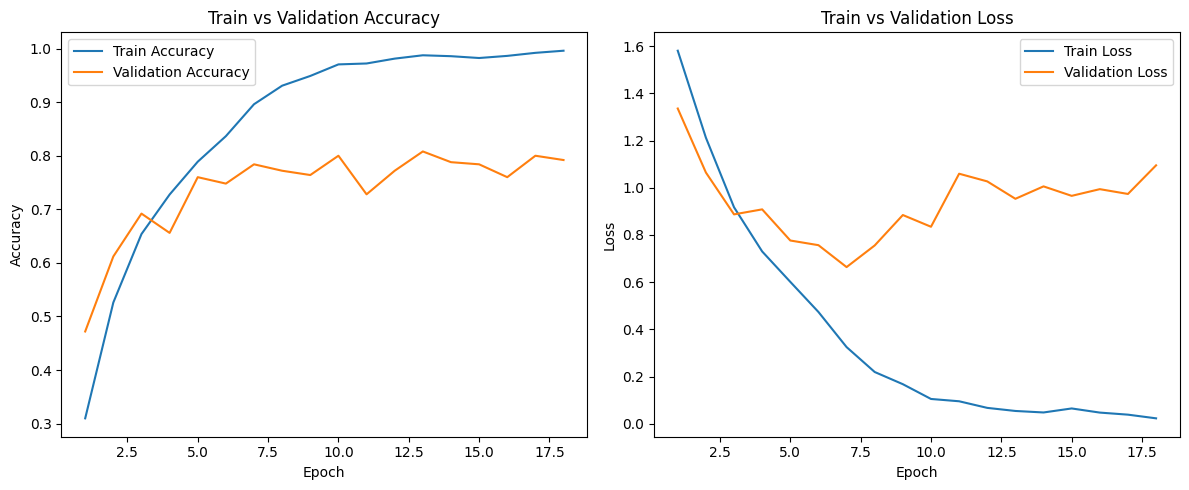

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


eğitilmiş CNN modelinin daha önce hiç görmediği test veri kümesi üzerindeki hata (loss) ve doğruluk (accuracy) değerlerini hesaplayarak modelin gerçek performansını ölçmektedir.

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.7869 - loss: 1.0939
Test Loss: 1.1334
Test Accuracy: 0.7917


test veri seti üzerinde modelin tahminlerini alarak gerçek etiketlerle karşılaştırmakta ve accuracy, balanced accuracy, MCC, precision, recall ve F1-score gibi farklı performans metriklerini hesaplayarak modelin başarımını kapsamlı şekilde değerlendirmektedir.

In [ ]:
y_true = []
y_pred = []
y_prob = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_prob.extend(preds)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

acc = accuracy_score(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)

print(f"Accuracy:          {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"MCC:               {mcc:.4f}")
print(f"Precision (w):     {prec:.4f}")
print(f"Recall (w):        {rec:.4f}")
print(f"F1-score (w):      {f1:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
Accuracy:          0.7917
Balanced Accuracy: 0.7886
MCC:               0.7407
Precision (w):     0.7954
Recall (w):        0.7917
F1-score (w):      0.7900


modelin test verisi üzerindeki tahminleri kullanılarak confusion matrix ve classification report oluşturulmuştur. Confusion matrix ile modelin hangi sınıfları doğru veya yanlış tahmin ettiği analiz edilirken, classification report ile precision, recall ve F1-score gibi detaylı performans metrikleri sınıf bazında değerlendirilmiştir.

In [ ]:
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Confusion Matrix:
 [[90  7  3  3  2]
 [15 60  4  8  6]
 [ 2  2 81 12  8]
 [ 2  2  8 91  1]
 [ 4  0 11  6 81]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.80      0.86      0.83       105
      Mosaic       0.85      0.65      0.73        93
      RedRot       0.76      0.77      0.76       105
        Rust       0.76      0.88      0.81       104
      Yellow       0.83      0.79      0.81       102

    accuracy                           0.79       509
   macro avg       0.80      0.79      0.79       509
weighted avg       0.80      0.79      0.79       509



modelin test verisi üzerindeki tahminlerini gerçek sınıflarla karşılaştırarak bir confusion matrix oluşturur ve bu matrisi ısı haritası (heatmap) şeklinde görselleştirerek modelin hangi sınıflarda doğru veya yanlış tahmin yaptığını açıkça göstermeyi sağlar.

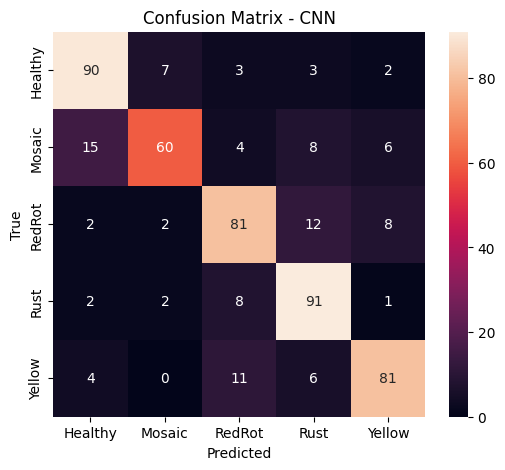

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN")
plt.show()


CNN modelinin test verisindeki tahmin olasılıklarını kullanarak her sınıf için (one-vs-rest) ROC eğrilerini ve AUC değerlerini hesaplar, ayrıca tüm sınıfların ortalamasını (macro-average) çıkarıp hepsini tek bir grafikte çizer.

ROC–AUC, modelin “iyi ile kötüyü ne kadar iyi ayırabildiğini” gösterir; AUC değeri 1’e ne kadar yakınsa model o kadar iyidir.


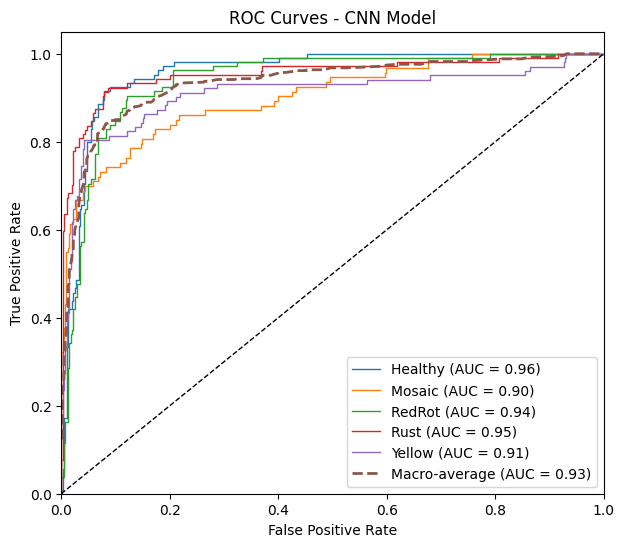

In [ ]:
# one-vs-rest binarize
y_true_bin = label_binarize(y_true, classes=range(num_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(7, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=1,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot(all_fpr, mean_tpr, linestyle='--', lw=2,
         label=f"Macro-average (AUC = {roc_auc['macro']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - CNN Model")
plt.legend(loc="lower right")
plt.show()


eğitim, doğrulama ve test klasörlerindeki resimleri okuyarak tüm resimleri aynı boyuta getirir, sınıflarını klasör isimlerinden otomatik belirler ve modeli eğitmek ve değerlendirmek için kullanılacak veri setlerini hazırlar.

In [ ]:
import tensorflow as tf
import os

# Aynı dizinler:
# train_dir, val_dir, test_dir zaten yukarıda tanımlı olmalı

svm_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

svm_val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

svm_test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

class_names = svm_train_ds.class_names
num_classes = len(class_names)
print("Sınıflar:", class_names)


Found 1762 files belonging to 5 classes.
Found 250 files belonging to 5 classes.
Found 509 files belonging to 5 classes.
Sınıflar: ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']


eğitilmiş CNN modelinin sınıflandırma kısmını devre dışı bırakarak, resimleri 256 boyutlu sayısal özellik vektörlerine dönüştüren bir feature extractor modeli oluşturur

Resmi sayılara çeviriyoruz
Bu sayıları SVM gibi başka modellerde kullanabiliriz

CNN modelinin girişten itibaren görüntüyü adım adım küçülterek ve özellik çıkararak işlediğini, ardından bu özellikleri yoğun (Dense) bir katmanda yorumlayarak karar verdiğini ve toplamda yaklaşık 25.8 milyon öğrenilebilir parametreye sahip olduğunu göstermektedir.

In [ ]:
from tensorflow.keras import Model

# model.layers[-1]  -> son Dense (num_classes)
# model.layers[-2]  -> Dropout
# model.layers[-3]  -> Dense(256)  (feature vektörü)
feature_extractor = Model(
    inputs=model.inputs[0], # Değişiklik burada: model.input yerine model.inputs[0]
    outputs=model.layers[-3].output
)

feature_extractor.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_11 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │    25,690,368 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,783,616 (98.36 MB)

 Trainable params: 25,783,616 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

Bu fonksiyon, bir CNN modelini kullanarak resimlerden sayısal özellikler çıkarır ve bu özellikleri gerçek sınıf etiketleriyle birlikte makine öğrenmesi modellerinde kullanılabilecek hale getirir.

resimleri CNN’e veriyor, karar vermeden önceki bilgileri alıyor, bunları sayılara çevirip saklıyor


CNN modeli, havuzlama katmanları ile uzamsal boyutları azaltarak önemli özellikleri korur, Flatten katmanı ile bu özellikleri vektöre dönüştürür ve Dense(256) katmanı aracılığıyla görüntüyü 256 boyutlu bir özellik temsiline indirger.

In [ ]:
import numpy as np

def extract_features_and_labels(dataset, feature_model):
    all_features = []
    all_labels = []

    for images, labels in dataset:
        # CNN’den feature çıkar
        feats = feature_model.predict(images)
        all_features.append(feats)

        # one-hot -> class index
        all_labels.append(np.argmax(labels.numpy(), axis=1))

    X = np.concatenate(all_features, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y


eğitilmiş CNN modeli kullanılarak eğitim, doğrulama ve test veri kümelerindeki görüntülerden özellikler çıkarılmış; eğitim ve doğrulama özellikleri birleştirilerek SVM modeli için eğitim verisi hazırlanmış ve test verileri yalnızca nihai performans değerlendirmesi için ayrılmıştır.

In [ ]:
# Train ve Val feature'larını çıkar
X_train, y_train = extract_features_and_labels(svm_train_ds, feature_extractor)
X_val,   y_val   = extract_features_and_labels(svm_val_ds, feature_extractor)

# Train + Val'i birleştir (daha fazla veri = daha iyi SVM)
X_svm_train = np.concatenate([X_train, X_val], axis=0)
y_svm_train = np.concatenate([y_train, y_val], axis=0)

# Test feature'ları
X_svm_test, y_svm_test = extract_features_and_labels(svm_test_ds, feature_extractor)

print("X_svm_train shape:", X_svm_train.shape)
print("y_svm_train shape:", y_svm_train.shape)
print("X_svm_test shape :", X_svm_test.shape)
print("y_svm_test shape :", y_svm_test.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/st

In [ ]:
!pip install scikit-learn


CNN’den çıkarılan feature’lar üzerinde farklı SVM ayarlarını 3 katlı çapraz doğrulama ile deneyerek en yüksek doğruluğu veren SVM modelini otomatik olarak bulur.


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# SVM modeli (probability=True: ROC/AUC için lazım)
svm = SVC(probability=True)

param_grid = {
    "C": [0.1, 1, 10],
    "gamma": [0.001, 0.01, 0.1],
    "kernel": ["rbf"]
}

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=3,                 # 3-fold cross-validation
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_svm_train, y_svm_train)

print("En iyi parametreler:", grid_search.best_params_)
print("En iyi cross-val accuracy:", grid_search.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
En iyi parametreler: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
En iyi cross-val accuracy: 0.9721422692795337


GridSearchCV ile denenmiş SVM modellerinin sonuçlarını tablo haline getirerek, farklı C ve gamma parametrelerinin ortalama doğruluk değerlerini karşılaştırmayı ve en iyi performans gösteren parametre kombinasyonlarını kolayca incelemeyi sağlar.


In [ ]:
import pandas as pd

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[["param_C", "param_gamma", "mean_test_score", "std_test_score"]].sort_values(
    by="mean_test_score", ascending=False
).head()


,param_C,param_gamma,mean_test_score,std_test_score
3,1.0,0.001,0.972142,0.035182
6,10.0,0.001,0.968663,0.034838
0,0.1,0.001,0.955747,0.029863
4,1.0,0.010,0.928905,0.038968
7,10.0,0.010,0.927913,0.038869


GridSearchCV ile denenen tüm SVM modelleri arasından en iyi performansa sahip olan model seçilmektedir. Seçilen bu model kullanılarak, test verileri için hem sınıf tahminleri (predict) hem de her sınıfa ait olasılık değerleri (predict_proba) hesaplanmaktadır. Elde edilen olasılık değerleri, model performansını ROC eğrisi ve AUC metriği ile değerlendirmek için kullanılmaktadır.

In [ ]:
best_svm = grid_search.best_estimator_

# Test tahmini
y_svm_pred = best_svm.predict(X_svm_test)
y_svm_prob = best_svm.predict_proba(X_svm_test)  # ROC/AUC için


SVM modelinin test verileri üzerindeki başarımını birden fazla performans metriği ile değerlendirmek için kullanılır. Accuracy ve Balanced Accuracy genel doğruluğu ölçerken, MCC sınıf dengesizliğini de dikkate alan daha güvenilir bir performans göstergesidir. Precision, Recall ve F1-score ise modelin sınıfları ne kadar doğru ve dengeli tahmin ettiğini özetleyerek, modelin genel sınıflandırma kalitesini ortaya koyar.


In [ ]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, matthews_corrcoef,
    precision_recall_fscore_support, classification_report,
    confusion_matrix
)

acc = accuracy_score(y_svm_test, y_svm_pred)
bal_acc = balanced_accuracy_score(y_svm_test, y_svm_pred)
mcc = matthews_corrcoef(y_svm_test, y_svm_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_svm_test, y_svm_pred, average='weighted', zero_division=0
)

print("=== SVM Sonuçları (Test) ===")
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"MCC:               {mcc:.4f}")
print(f"Precision (w):     {prec:.4f}")
print(f"Recall (w):        {rec:.4f}")
print(f"F1-score (w):      {f1:.4f}")


=== SVM Sonuçları (Test) ===
Accuracy:          0.7996
Balanced Accuracy: 0.7963
MCC:               0.7507
Precision (w):     0.8051
Recall (w):        0.7996
F1-score (w):      0.7983


VM modelinin test verileri üzerindeki sınıflandırma sonuçlarını karışıklık matrisi (confusion matrix) ve sınıflandırma raporu ile ayrıntılı olarak analiz eder. Confusion matrix, modelin her sınıf için doğru ve yanlış tahmin sayılarını göstererek hangi sınıfların karıştırıldığını ortaya koyar. Classification report ise her sınıf için precision, recall ve F1-score değerlerini sunarak modelin sınıf bazlı performansını özetler.

In [ ]:
cm_svm = confusion_matrix(y_svm_test, y_svm_pred)

print("\nConfusion Matrix (SVM):\n", cm_svm)
print("\nClassification Report (SVM):")
print(classification_report(y_svm_test, y_svm_pred, target_names=class_names))



Confusion Matrix (SVM):
 [[92  5  3  3  2]
 [16 61  3  8  5]
 [ 4  2 86  7  6]
 [ 3  2  9 89  1]
 [ 5  1 15  2 79]]

Classification Report (SVM):
              precision    recall  f1-score   support

     Healthy       0.77      0.88      0.82       105
      Mosaic       0.86      0.66      0.74        93
      RedRot       0.74      0.82      0.78       105
        Rust       0.82      0.86      0.84       104
      Yellow       0.85      0.77      0.81       102

    accuracy                           0.80       509
   macro avg       0.81      0.80      0.80       509
weighted avg       0.81      0.80      0.80       509



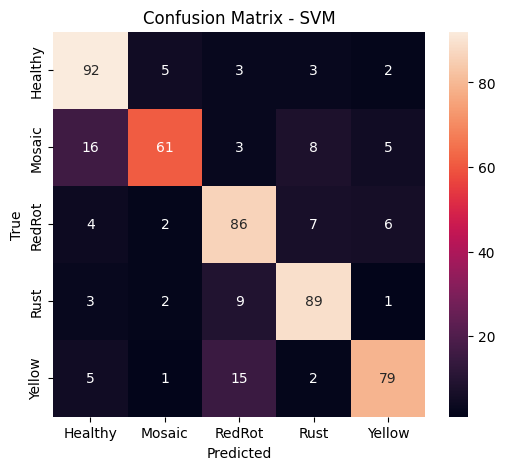

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - SVM")
plt.show()


SVM modelinin çok sınıflı ROC eğrilerini ve her sınıf için AUC değerlerini hesaplayıp görselleştirmektedir. Her sınıf için ayrı ROC eğrisi çizilirken, modelin genel performansını göstermek amacıyla makro ortalama ROC eğrisi de hesaplanmaktadır. Elde edilen ROC–AUC değerleri, modelin sınıfları ayırt etme başarısını görsel ve sayısal olarak değerlendirmeyi sağlar.

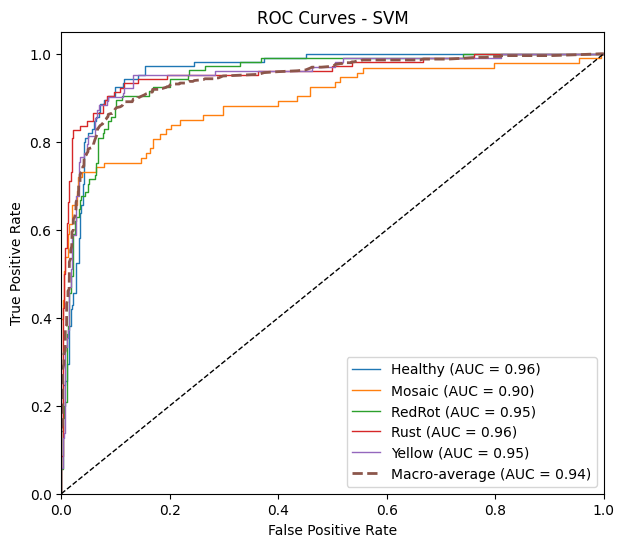

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_svm_test, classes=range(num_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_svm_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Makro ortalama
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(7, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=1,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot(all_fpr, mean_tpr, linestyle='--', lw=2,
         label=f"Macro-average (AUC = {roc_auc['macro']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - SVM")
plt.legend(loc="lower right")
plt.show()


In [ ]:
import joblib
import os

# SVM'i kaydedeceğimiz yol
svm_model_path = os.path.join(BASE_DIR, "best_svm_model.joblib")

# best_svm: GridSearchCV'den gelen en iyi model
joblib.dump(best_svm, svm_model_path)

print("SVM modeli kaydedildi:", svm_model_path)


SVM modeli kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sugarcane Disease/best_svm_model.joblib
